**Part A**

Save all the possible classifications that will be tested into a file for later use. 

In [1]:
%matplotlib inline

In [2]:
from analysis_tree_helpers import HTree, Node, get_valid_classifications
import scipy.io as sio
import pandas as pd

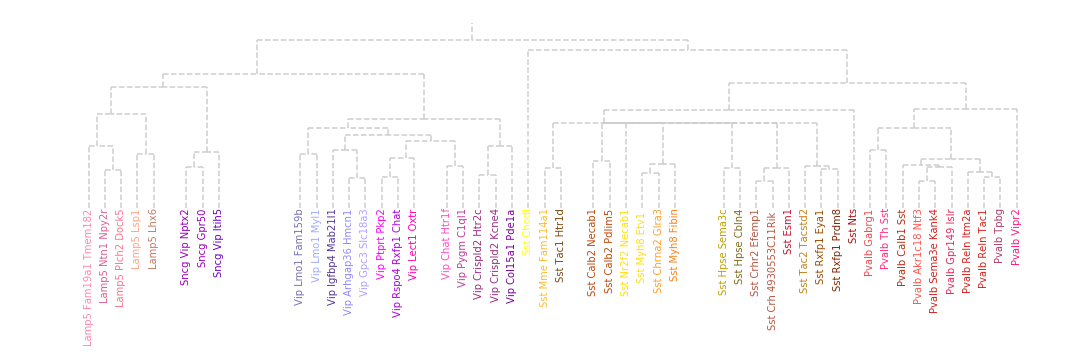

In [3]:
simple_tree_filename = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220_pruned.csv'
htree_df = pd.read_csv(simple_tree_filename)
htree = HTree(htree_df=htree_df)
htree.plot((15,5),fontsize=10,skeletoncol='#CDCDCD',ls='--',txtleafonly=True)
ax = plt.gca()
ax.set_xlim(30,95)
ax.axis('off')
plt.tight_layout()
#plt.savefig('/Users/fruity/Desktop/RefHtree.png',dpi=300)

In [5]:
#Show dataset distribution
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

In [9]:
(lbl,count) = np.unique(O['cluster'],return_counts=True)
x=[]
y=[]
col=[]
for l in lbl:
    x.append(htree.x[htree.child==l])
    y.append(count[lbl==l])
    col.append(htree.col[htree.child==l])
x = np.array(x).flatten()
y = np.array(y).flatten()
col = np.array(col).flatten()    

In [10]:
ind = np.argsort(x)
xsort = np.empty(x.shape)
xtemp = np.arange(x.size)*60/x.size
xsort[ind] = xtemp

0

ValueError: shape mismatch: objects cannot be broadcast to a single shape

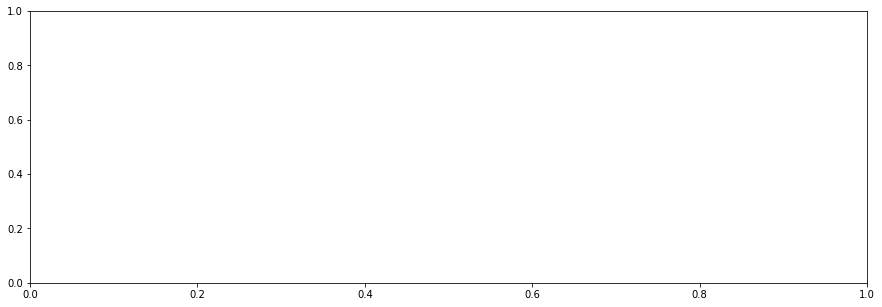

In [24]:
plt.figure(figsize = (15,5))
plt.bar(x=x,height=count,width=0.5,color=col,edgecolor='w')
for i in range(len(x)):
    plt.text(x[i], y[i]+5, '('+str(y[i])+') '+lbl[i],color=col[i],
             horizontalalignment='center',
             verticalalignment='bottom', 
             rotation=90, 
             fontsize=10) 

ax = plt.gca()    
ax.set_frame_on(False)
ax.set_xticks([])
plt.tight_layout()
plt.savefig('/Users/fruity/Desktop/Hist.png',dpi=300)
plt.show()

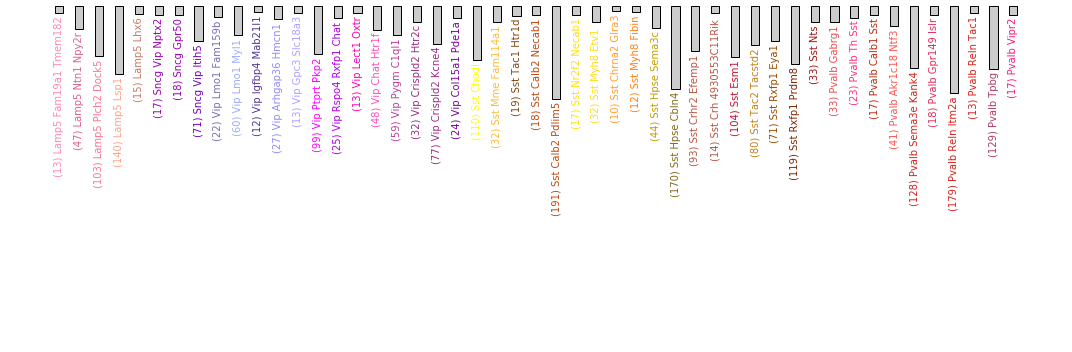

In [31]:
plt.figure(figsize = (15,5))
plt.bar(x=xsort,height=-count,width=0.5,color='#CCCCCC',edgecolor='k')
for i in range(len(x)):
    plt.text(xsort[i], -y[i]-5, '('+str(y[i])+') '+lbl[i],color=col[i],
             horizontalalignment='center',
             verticalalignment='top', 
             rotation=90, 
             fontsize=10) 

ax = plt.gca()    
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-700,0)
plt.tight_layout()
plt.savefig('/Users/fruity/Desktop/Hist.png',dpi=300)
plt.show()

In [ ]:
##### from timebudget import timebudget

with timebudget('Calculate valid classifications'):
    valid_classifications = {}
    for n in ['n60','n88']:
        print('Subtree with root node: {:s}'.format(n))
        subtree = htree.get_subtree(node=n)
        start_node = Node(name=n,C_list=subtree.child,P_list=subtree.parent)
        valid_classifications[n]=[]
        valid_classifications[n] = get_valid_classifications([start_node],
                                                          C_list=subtree.child,
                                                          P_list=subtree.parent,
                                                          valid_classes=valid_classifications[n])

    for n in ['n60','n88']:
        valid_classifications[n].sort(key=len)
        hist_counts = pd.Series([len(classification) for classification in valid_classifications[n]]).value_counts().to_frame()
        hist_counts.reset_index(inplace=True)
        hist_counts = hist_counts.rename(columns={'index':'n_classes',0:'classifications'}).sort_values(by='n_classes').reset_index(drop=True)

        print(hist_counts.to_string())
        print('Total: {:d} \n'.format(len(valid_classifications[n])))

In [7]:
#Save dictionary in json format:
import json
classifications_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
classifications_fname = 'PS_v4_beta_0-4_matched_well-sampled_dend_RData_Tree_20181220_pruned_n88_n60_classifications.json'
json_file = json.dumps(valid_classifications)
#with open(classifications_path+classifications_fname,"w") as f:
#    f.write(json_file)

**Part B** Implemented in `analysis_parallel_classifier.py`

Test set values will be used only once the best classification has been chosen based on validation set results. 
 - Read single cross validation set data
 - Loop over pre-defined classifications
 - Relabel all training, validation, and test set data with merged labels
 - Train a logistic regression model
 - Log hyperparameters, cvset, classification_id, accuracy and ARI for training, validation, and test sets using the classifier.
 
```python
# Most time consuming case:
this_classification = all_classifications[root_node][-1]

# Subtree over which brute force classification is performed:
root_node='n59'
this_classification = ['n60','n88'] #accuracy for this is over 99%
this_classification = ['n76','n63','Sst Chodl','n90','n109']
 ```
 

In [1]:
import csv
import json
import argparse
import sys
import pdb

import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score
from timebudget import timebudget

from analysis_tree_helpers import HTree


def relabel_restrict_inputs(CV=None,O=None,this_classification=[],descendant_dict={}):
    """Restrict the train, validation and test subsets to relevant portion of the tree, and relabel according to current classification being considered.
    
    Arguments:
        CV -- dict with one of the cross validation sets, with fields `zT`, `zE`, `train_ind`,`val_ind`,`test_ind`
        O -- dict with annotation field `cluster`
        this_classification -- list of labels remaining in the classificaiton
        descendant_dict -- dict with descendants based on the tree
    
    Returns:
        X -- dictionary with train,val and test subsets to train the classifiers.
    """

    X={}
    #Initialize
    for ds in ['train','val','test']:
        X[ds]={}
        X[ds]['zT']=CV['zT'][CV[ds+'_ind'],:].copy()
        X[ds]['zE']=CV['zE'][CV[ds+'_ind'],:].copy()
        X[ds]['orig_cluster']=O['cluster'][CV[ds+'_ind']].copy()
        X[ds]['cluster']=np.array(['rem']*X[ds]['zT'].shape[0],dtype=X[ds]['orig_cluster'].dtype)


    #Relabel
    for ds in ['train','val','test']:
        for label in this_classification:
            #Leaf nodes have an empty value in descendant_dict
            if len(descendant_dict[label])==0:
                X[ds]['cluster'][np.isin(X[ds]['orig_cluster'],label)] = label
            else:
                X[ds]['cluster'][np.isin(X[ds]['orig_cluster'],descendant_dict[label])] = label

    #Remove labels not in current classification
    for ds in ['train','val','test']:
        keep = X[ds]['cluster']!='rem'
        X[ds]['zT']=X[ds]['zT'][keep,:]
        X[ds]['zE']=X[ds]['zE'][keep,:]
        X[ds]['cluster']=X[ds]['cluster'][keep]
        X[ds]['orig_cluster']=X[ds]['orig_cluster'][keep]
    
    return X

def set_paths(exp_name='logistic_classifiers'):
    """Set data paths
    """

    from pathlib import Path   
    dir_pth = {}
    curr_path = str(Path().absolute())
    if '/Users/fruity' in curr_path:
        base_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/'
        dir_pth['data'] = base_path + 'dat/raw/patchseq-v4/'
    elif '/home/rohan' in curr_path:
        base_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/'
        dir_pth['data'] = base_path + 'dat/raw/patchseq-v4/'
    elif '/allen' in curr_path:
        base_path = '/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/'
        dir_pth['data'] = base_path + 'dat/raw/patchseq-v4/'

    dir_pth['cvfolds'] = base_path + 'dat/result/TE_Patchseq_Bioarxiv/'
    dir_pth['result'] = dir_pth['cvfolds'] + exp_name + '/'

    Path(dir_pth['result']).mkdir(parents=True, exist_ok=True)
    return dir_pth

In [2]:
cvfold=1
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
root_node='n88'
start_i=0
stop_i=11000
embedding='zE'
rand_seed=0
exp_name='TEST'

alpha_M=alpha_E
cvfold_fname='v2_aT_'+str(alpha_T)+\
            '_aE_'+str(alpha_E)+\
            '_aM_'+str(alpha_M)+\
            '_cs_'+str(lambda_TE)+\
            '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cvfold)+\
            '_ri_0500_ft-summary'
cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
dir_pth = set_paths(exp_name=exp_name)

#Load pruned tree, embeddings, and cell type annotations
with open(dir_pth['data']+"PS_v4_beta_0-4_matched_well-sampled_dend_RData_Tree_20181220_pruned_n88_n60_classifications.json") as f:
    all_classifications = json.load(f)        
O = sio.loadmat(dir_pth['data']+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)
CV = sio.loadmat(dir_pth['cvfolds']+cvfold_fname,squeeze_me=True)
htree_df = pd.read_csv(dir_pth['data']+'dend_RData_Tree_20181220_pruned.csv')
htree = HTree(htree_df=htree_df)
all_descendants = htree.get_all_descendants()

In [7]:
O['T_dat'].shape

(2702, 1252)

In [3]:
print(len(all_classifications['n88']))
print(len(all_classifications['n60']))

6106
2993


In [4]:
#max_i = min(stop_i,len(all_classifications[root_node]))
root_node='n88'
start_i = 10
max_i = 11
for i in range(start_i,max_i,1):
    #print('Iter {:6d} in range {:6d} to {:6d}'.format(i,start_i,max_i))
    classification_id = root_node+'_'+str(i)
    this_classification = all_classifications[root_node][i]

    #17 ['n60_2676']
    #18 ['n60_2864']
    #this_classification = all_classifications['n60'][2676]
    this_classification = all_classifications['n60'][2864]

    n_classes=len(this_classification)

    #Classifier only works for n_classes > 1 
    if n_classes>1: 
        X = relabel_restrict_inputs(CV=CV,O=O,this_classification=this_classification,descendant_dict=all_descendants)
        clf = LogisticRegression(penalty='none',
                                 random_state=rand_seed,
                                 solver='lbfgs',
                                 max_iter=10000,
                                 multi_class='multinomial', 
                                 class_weight='balanced').fit(X['train'][embedding], X['train']['cluster'])
        

        result={}
        for ds in ['train','val','test']:
            pred_label = clf.predict(X[ds][embedding])
            result[ds+'_acc'] = np.sum(pred_label==X[ds]['cluster'])/X[ds]['cluster'].size
            result[ds+'_ari'] = adjusted_rand_score(X[ds]['cluster'], pred_label)
            result[ds+'_ami'] = adjusted_mutual_info_score(X[ds]['cluster'], pred_label)
            result[ds+'_nmi'] = normalized_mutual_info_score(X[ds]['cluster'], pred_label)
            result[ds+'_samples'] = pred_label.size

        result_list = [result['train_acc'], result['val_acc'], result['test_acc'],
                       result['train_ari'], result['val_ari'], result['test_ari'],
                       result['train_ami'], result['val_ami'], result['test_ami'],
                       result['train_nmi'], result['val_nmi'], result['test_nmi'],
                       result['train_samples'], result['val_samples'], result['test_samples'],
                       cvfold, classification_id, n_classes]

        header = ['train_acc', 'val_acc', 'test_acc',
                  'train_ari', 'val_ari', 'test_ari',
                  'train_ami', 'val_ami', 'test_ami',
                  'train_nmi', 'val_nmi', 'test_nmi',
                  'train_samples', 'val_samples', 'test_samples',
                  'cvfold', 'classification_id', 'n_classes']
        
        print('\n===Results===')
        for h,r in zip(header,result_list):
            if type(r)==str:
                print('{:20s}{}'.format(h,r))
            else:
                print('{:20s}{:0.3f}'.format(h,r))



===Results===
train_acc           0.625
val_acc             0.465
test_acc            0.563
train_ari           0.570
val_ari             0.311
test_ari            0.438
train_ami           0.574
val_ami             0.383
test_ami            0.485
train_nmi           0.608
val_nmi             0.617
test_nmi            0.666
train_samples       733.000
val_samples         99.000
test_samples        103.000
cvfold              1.000
classification_id   n88_10
n_classes           18.000





**Part C** Analysis of the results:

In [1]:
%matplotlib inline

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis_tree_helpers import do_merges,HTree
import os
sns.set()

All the log files are merged using `cat cv* > combined_file` in bash.

For some `classification_id`, not all 9 cross validation sets were evaluated. 
- Writing to the same csv by different concurrent runs is likely cause
- At least 7/9 cv sets were evaluated for all such cases. So, it's okay to ignore the missing runs for now.

In [3]:
#Load all classifications evaluated:
dir_pth_data = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
with open(dir_pth_data+ 'PS_v4_beta_0-4_matched_well-sampled_dend_RData_Tree_20181220_pruned_n88_n60_classifications.json') as f:
    all_classifications = json.load(f)
    
#Load pruned tree
simple_tree_filename = dir_pth_data + 'dend_RData_Tree_20181220_pruned.csv'
htree_df = pd.read_csv(simple_tree_filename)
htree = HTree(htree_df=htree_df)

htree_cut_ids = []
for root_node in ['n60','n88']:
    subtree = htree.get_subtree(node=root_node)
    leaf_labels = subtree.child[subtree.isleaf]
    list_changes = subtree.get_mergeseq()
    
    for i in range(len(list_changes)):
        #Get a cut of the Tasic. hierarchical tree
        current_htree_cut = do_merges(labels=leaf_labels,list_changes=list_changes,n_merges=i)
        current_htree_cut = set(current_htree_cut)
        
        #Search for the current_htree_cut among all_classifications evaluated
        not_found=True
        count=0
        while not_found or count<len(all_classifications):    
            count=count+1
            if set(all_classifications[root_node][count])==current_htree_cut:
                htree_cut_ids.append('{:s}_{:d}'.format(root_node,count))
                not_found=False

In [ ]:
#Some lines are corrupted in the original csv.
import csv
csv_pth = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/LR_v1_bal/'
file_A = csv_pth+'cv_classification_results_zE-aT_1-0_aE_1-0_aM_1-0_csTE_1-0_randseed_0_combined.csv'
file_B = csv_pth+'cv_classification_results_zE-aT_1-0_aE_1-0_aM_1-0_csTE_1-0_randseed_0_combined_edited.csv'
with open(file_A, 'r') as inp, open(file_B, 'w') as out:
    writer = csv.writer(out)
    for row in csv.reader(inp):
        if len(row) == 12:
            writer.writerow(row)

In [ ]:
colnames = ['train_acc','val_acc','test_acc',
            'train_ari','val_ari','test_ari',
            'train_samples','val_samples','test_samples',
            'cvfold', 'classification_id', 'n_classes']

dtype_dict = {'train_acc':float,'val_acc':float,'test_acc':float,
            'train_ari':float,'val_ari':float,'test_ari':float,
            'train_samples':int,'val_samples':int,'test_samples':int,
            'cvfold':int, 'classification_id':str, 'n_classes':int}

#Logistic regression classifier
# data_pth = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/LR_v1/'
# X = pd.read_csv(data_pth+'cv_classification_results_zE_aT_1-0_aE_1-0_aM_1-0_csTE_1-0_randseed_0_combined.csv',
#                 header=None,names=colnames)

#Logistic regression classifier accounting for class imbalance
data_pth = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/LR_v1_bal/'
X = pd.read_csv(data_pth+'cv_classification_results_zE-aT_1-0_aE_1-0_aM_1-0_csTE_1-0_randseed_0_combined_edited.csv',
                header=None,names=colnames)

X.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
X = X.astype(dtype=dtype_dict)

In [4]:
data_pth = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/LR_v2_bal_zT_ld3/'
fnames = [f for f in os.listdir(data_pth) if '.csv' in f]
count = 0
for i,f in enumerate(fnames):
    if i==0:
        X = pd.read_csv(data_pth+f)
    else:
        Y = pd.read_csv(data_pth+f)
        X = pd.concat([X,Y],axis=0)

In [5]:
#Checks: Print classification ids for which some cvfolds were not evaluated:
s = [2993,6106]
for k,root_node in enumerate(['n60','n88']):
    cid = X['classification_id'].values.astype(str)
    cid=[int(i[4:]) for i in cid if i[0:3]==root_node]
    x = np.sort(np.array(cid))
    #plt.plot(np.isin(np.arange(s[k]),np.unique(x)),'.')
    #plt.show()
    for i in np.arange(1,s[k],1):
        if np.sum(x==i)<=7:
            print('{:4d}, {:4d}'.format(i,np.sum(x==i)))

In [15]:
train_meas = 'train_acc'
val_meas = 'val_acc'
test_meas = 'test_acc'
meas_name = 'Accuracy'

#Obtain the average over cross validation sets
Y = X.groupby('classification_id')[[train_meas,val_meas,test_meas,'n_classes']].mean().reset_index()

#Separate out the two groups of classifications tested and Select the best classification for each n_class value
Y_n60=Y[Y['classification_id'].str.contains("n60")]
idx = Y_n60.groupby(['n_classes'])[val_meas].transform(max) == Y_n60[val_meas]
Y_n60_max=Y_n60[idx]
Y_n60_max = Y_n60_max.sort_values(by='n_classes').reset_index(drop=True)

#Calculate std over the cvsets, for classification_ids that correspond to the max avg validation accuracy
X_n60_best_ids = X.loc[X['classification_id'].isin(Y_n60_max['classification_id'])]
Y_n60_best_ids_std = X_n60_best_ids.groupby(['classification_id','n_classes'])[[train_meas,val_meas,test_meas]].std().reset_index()
Y_n60_best_ids_std = Y_n60_best_ids_std.sort_values(by='n_classes').reset_index(drop=True)


#Separate out the two groups of classifications tested and Select the best classification for each n_class value
Y_n88=Y[Y['classification_id'].str.contains("n88")]
idx = Y_n88.groupby(['n_classes'])[val_meas].transform(max) == Y_n88[val_meas]
Y_n88_max=Y_n88[idx]
Y_n88_max = Y_n88_max.sort_values(by='n_classes').reset_index(drop=True)

#Calculate std over the cvsets, for classification_ids that correspond to the max avg validation accuracy
X_n88_best_ids = X.loc[X['classification_id'].isin(Y_n88_max['classification_id'])]
Y_n88_best_ids_std = X_n88_best_ids.groupby(['classification_id','n_classes'])[[train_meas,val_meas,test_meas]].std().reset_index()
Y_n88_best_ids_std = Y_n88_best_ids_std.sort_values(by='n_classes').reset_index(drop=True)

assert np.array_equal(Y_n88_max['n_classes'].values,Y_n88_best_ids_std['n_classes'].values), 'Order of ids is not correct'
assert np.array_equal(Y_n60_max['n_classes'].values,Y_n60_best_ids_std['n_classes'].values), 'Order of ids is not correct'

#Select the specific cuts among evaluated all_classifications based on ids.
Y_htree_cuts = Y.loc[Y['classification_id'].isin(htree_cut_ids)]
Y_htree_cuts_n60=Y_htree_cuts[Y_htree_cuts['classification_id'].str.contains("n60")]
Y_htree_cuts_n88=Y_htree_cuts[Y_htree_cuts['classification_id'].str.contains("n88")]

Y_htree_cuts_n60 = Y_htree_cuts_n60.sort_values(by='n_classes').reset_index(drop=True)
Y_htree_cuts_n88 = Y_htree_cuts_n88.sort_values(by='n_classes').reset_index(drop=True)

#Calculate std over cross validation sets for the hierarchical tree cuts
X_htree_cuts = X.loc[X['classification_id'].isin(htree_cut_ids)]

X_n60_htree_cuts = X_htree_cuts.loc[X_htree_cuts['classification_id'].isin(Y_htree_cuts_n60['classification_id'])]
Y_n60_htree_cuts_std = X_n60_htree_cuts.groupby(['classification_id','n_classes'])[[train_meas,val_meas,test_meas]].std().reset_index()
Y_n60_htree_cuts_std = Y_n60_htree_cuts_std.sort_values(by='n_classes').reset_index(drop=True)
assert np.array_equal(Y_htree_cuts_n60['n_classes'].values,Y_n60_htree_cuts_std['n_classes'].values), 'Order of ids is not correct'

X_n88_htree_cuts = X_htree_cuts.loc[X_htree_cuts['classification_id'].isin(Y_htree_cuts_n88['classification_id'])]
Y_n88_htree_cuts_std = X_n88_htree_cuts.groupby(['classification_id','n_classes'])[[train_meas,val_meas,test_meas]].std().reset_index()
Y_n88_htree_cuts_std = Y_n88_htree_cuts_std.sort_values(by='n_classes').reset_index(drop=True)
assert np.array_equal(Y_htree_cuts_n88['n_classes'].values,Y_n88_htree_cuts_std['n_classes'].values), 'Order of ids is not correct'

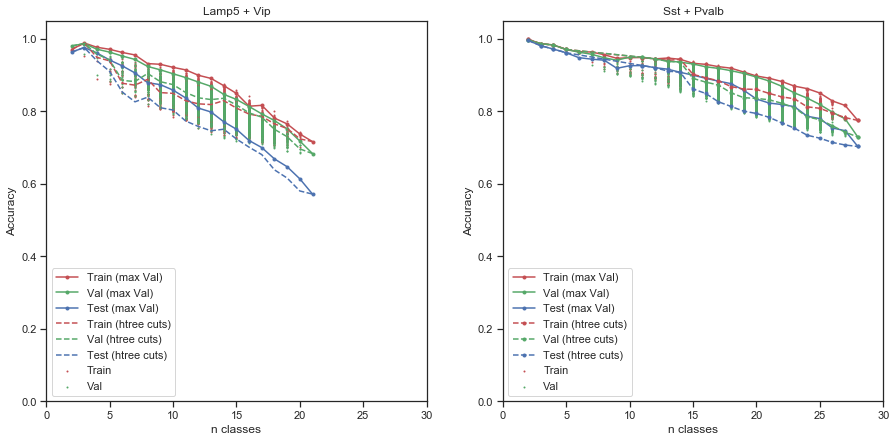

In [16]:
#plot training and validation accuracy for all the classifications:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.scatter(Y_n60['n_classes'].values,Y_n60[train_meas].values,s=1,c='r',alpha = 1,label='Train')
plt.scatter(Y_n60['n_classes'].values,Y_n60[val_meas].values,s=1,c='g',alpha = 1,label='Val')

plt.plot(Y_n60_max['n_classes'].values,Y_n60_max[train_meas].values,'.-',c='r',label='Train (max Val)')
plt.plot(Y_n60_max['n_classes'].values,Y_n60_max[val_meas].values,'.-',c='g',label='Val (max Val)')
plt.plot(Y_n60_max['n_classes'].values,Y_n60_max[test_meas].values,'.-',c='b',label='Test (max Val)')

plt.plot(Y_htree_cuts_n60['n_classes'].values,Y_htree_cuts_n60[train_meas].values,'--',c='r',label='Train (htree cuts)')
plt.plot(Y_htree_cuts_n60['n_classes'].values,Y_htree_cuts_n60[val_meas].values,'--',c='g',label='Val (htree cuts)')
plt.plot(Y_htree_cuts_n60['n_classes'].values,Y_htree_cuts_n60[test_meas].values,'--',c='b',label='Test (htree cuts)')

ax = plt.gca()
ax.set_xlim(0,30)
ax.set_ylim(0,1.05)
ax.set_ylabel(meas_name)
ax.set_xlabel('n classes')
ax.set_title('Lamp5 + Vip')
plt.legend()


plt.subplot(122)
plt.scatter(Y_n88['n_classes'].values,Y_n88[train_meas].values,s=1,c='r',alpha = 1,label='Train')
plt.scatter(Y_n88['n_classes'].values,Y_n88[val_meas].values,s=1,c='g',alpha = 1,label='Val')

plt.plot(Y_n88_max['n_classes'].values,Y_n88_max[train_meas].values,'.-',c='r',label='Train (max Val)')
plt.plot(Y_n88_max['n_classes'].values,Y_n88_max[val_meas].values,'.-',c='g',label='Val (max Val)')
plt.plot(Y_n88_max['n_classes'].values,Y_n88_max[test_meas].values,'.-',c='b',label='Test (max Val)')

plt.plot(Y_htree_cuts_n88['n_classes'].values,Y_htree_cuts_n88[train_meas].values,'.--',c='r',label='Train (htree cuts)')
plt.plot(Y_htree_cuts_n88['n_classes'].values,Y_htree_cuts_n88[val_meas].values,'.--',c='g',label='Val (htree cuts)')
plt.plot(Y_htree_cuts_n88['n_classes'].values,Y_htree_cuts_n88[test_meas].values,'.--',c='b',label='Test (htree cuts)')

ax = plt.gca()
ax.set_xlim(0,30)
ax.set_ylim(0,1.05)
ax.set_ylabel(meas_name)
ax.set_xlabel('n classes')
ax.set_title('Sst + Pvalb')
plt.legend()
plt.show()

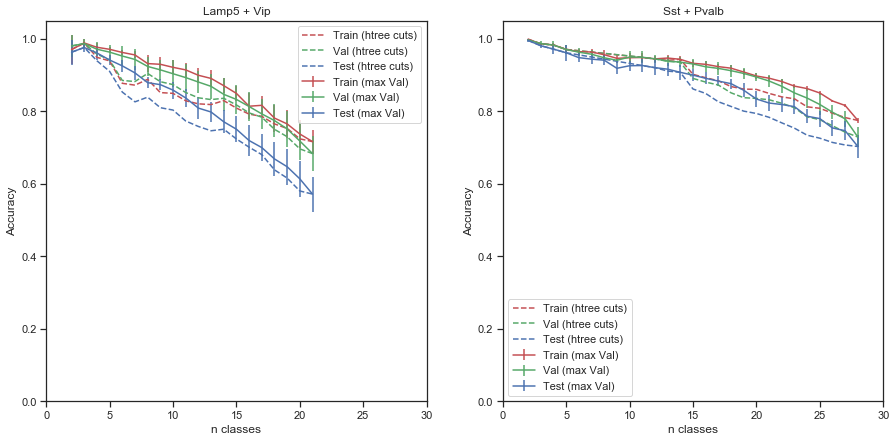

In [17]:
#plot training and validation accuracy for all the classifications:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.errorbar(Y_n60_max['n_classes'].values,
             Y_n60_max[train_meas].values,
             Y_n60_best_ids_std[train_meas].values,c='r',label='Train (max Val)')

plt.errorbar(Y_n60_max['n_classes'].values,
             Y_n60_max[val_meas].values,
             Y_n60_best_ids_std[val_meas].values,c='g',label='Val (max Val)')

plt.errorbar(Y_n60_max['n_classes'].values,
             Y_n60_max[test_meas].values,
             Y_n60_best_ids_std[test_meas].values,c='b',label='Test (max Val)')

plt.plot(Y_htree_cuts_n60['n_classes'].values,Y_htree_cuts_n60[train_meas].values,'--',c='r',label='Train (htree cuts)')
plt.plot(Y_htree_cuts_n60['n_classes'].values,Y_htree_cuts_n60[val_meas].values,'--',c='g',label='Val (htree cuts)')
plt.plot(Y_htree_cuts_n60['n_classes'].values,Y_htree_cuts_n60[test_meas].values,'--',c='b',label='Test (htree cuts)')

ax = plt.gca()
ax.set_xlim(0,30)
ax.set_ylim(0,1.05)
ax.set_ylabel(meas_name)
ax.set_xlabel('n classes')
ax.set_title('Lamp5 + Vip')
plt.legend()

plt.subplot(122)
plt.errorbar(Y_n88_max['n_classes'].values,
             Y_n88_max[train_meas].values,
             Y_n88_best_ids_std[train_meas].values,c='r',label='Train (max Val)')

plt.errorbar(Y_n88_max['n_classes'].values,
             Y_n88_max[val_meas].values,
             Y_n88_best_ids_std[val_meas].values,c='g',label='Val (max Val)')

plt.errorbar(Y_n88_max['n_classes'].values,
             Y_n88_max[test_meas].values,
             Y_n88_best_ids_std[test_meas].values,c='b',label='Test (max Val)')

plt.plot(Y_htree_cuts_n88['n_classes'].values,Y_htree_cuts_n88[train_meas].values,'--',c='r',label='Train (htree cuts)')
plt.plot(Y_htree_cuts_n88['n_classes'].values,Y_htree_cuts_n88[val_meas].values,'--',c='g',label='Val (htree cuts)')
plt.plot(Y_htree_cuts_n88['n_classes'].values,Y_htree_cuts_n88[test_meas].values,'--',c='b',label='Test (htree cuts)')

ax = plt.gca()
ax.set_xlim(0,30)
ax.set_ylim(0,1.05)
ax.set_ylabel(meas_name)
ax.set_xlabel('n classes')
ax.set_title('Sst + Pvalb')
plt.legend()
plt.show()

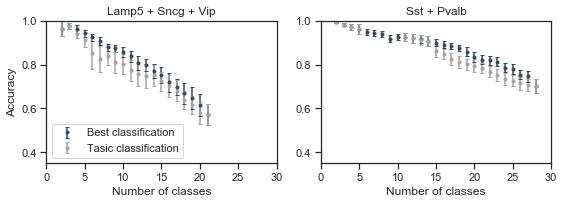

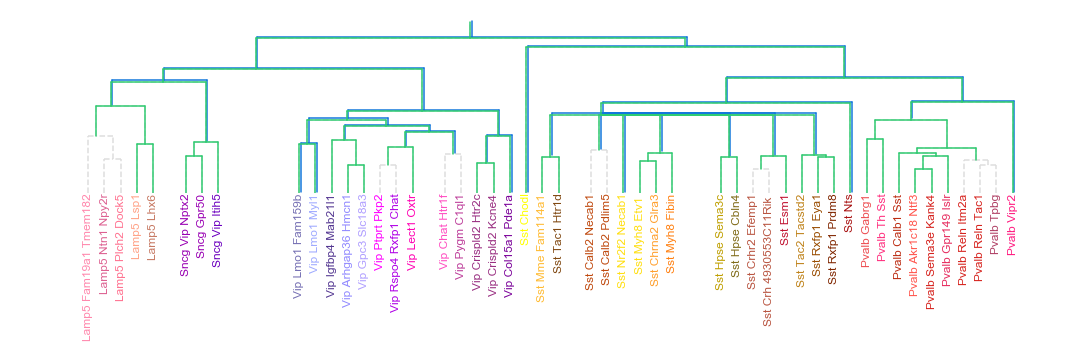

In [19]:
save_pth = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/'
c_tree_1 = "#1177db"
c_tree_2 = "#2ecc71"

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.errorbar(Y_n60_max['n_classes'].values,
             Y_n60_max[test_meas].values,
             Y_n60_best_ids_std[test_meas].values,fmt='.',c= "#34495e",label='Best classification',capsize=2)

best_ind_60 = Y_n60_max['n_classes']==9
best_ind_60_2 = Y_n60_max['n_classes']==17
#plt.plot(Y_n60_max[best_ind_60]['n_classes'].values,Y_n60_max[best_ind_60][test_meas].values,'s',c=c_tree_1)
#plt.plot(Y_n60_max[best_ind_60_2]['n_classes'].values,Y_n60_max[best_ind_60_2][test_meas].values,'s',c=c_tree_2)

plt.errorbar(Y_htree_cuts_n60['n_classes'].values,
             Y_htree_cuts_n60[test_meas].values,
             Y_n60_htree_cuts_std[test_meas].values,fmt='.',c= "#a5a5a5",label='Tasic classification',capsize=2)

ax = plt.gca()
ax.set_xlim(0,30)
ax.set_ylim(0.35,1)
ax.set_ylabel(meas_name)
ax.set_xlabel('Number of classes')
ax.set_title('Lamp5 + Sncg + Vip')
plt.legend()

plt.subplot(122)
plt.errorbar(Y_n88_max['n_classes'].values,
             Y_n88_max[test_meas].values,
             Y_n88_best_ids_std[test_meas].values,fmt='.',c="#34495e",label='Best classification',capsize=2)

best_ind_88 = Y_n88_max['n_classes']==11
best_ind_88_2 = Y_n88_max['n_classes']==24
#plt.plot(Y_n88_max[best_ind_88]['n_classes'].values,Y_n88_max[best_ind_88][test_meas].values,'s',c=c_tree_1)
#plt.plot(Y_n88_max[best_ind_88_2]['n_classes'].values,Y_n88_max[best_ind_88_2][test_meas].values,'s',c=c_tree_2)

plt.errorbar(Y_htree_cuts_n88['n_classes'].values,
             Y_htree_cuts_n88[test_meas].values,
             Y_n88_htree_cuts_std[test_meas].values,fmt='.',c="#a5a5a5",label='Tasic classification',capsize=2)

ax = plt.gca()
ax.set_xlim(0,30)
ax.set_ylim(0.35,1)
#ax.set_ylabel(meas_name)
ax.set_xlabel('Number of classes')
ax.set_title('Sst + Pvalb')
#plt.legend()
plt.tight_layout()
plt.savefig(save_pth+'zT_Accuracy_3d.png',dpi=300)
#--------------------------------------------------------------------------

cid_60 = int(Y_n60_max[best_ind_60]['classification_id'].values[0][4:])
cid_88 = int(Y_n88_max[best_ind_88]['classification_id'].values[0][4:])

kept_classes = all_classifications['n60'][cid_60] + all_classifications['n88'][cid_88]
kepttree_nodes=[]
for node in kept_classes:
    kepttree_nodes.extend(htree.get_ancestors(node))
    kepttree_nodes.extend([node])

kept_subtree_df = htree.obj2df()
kept_subtree=HTree(htree_df=kept_subtree_df[kept_subtree_df['child'].isin(kepttree_nodes)])

#Tree number 2 starts----------
cid_60_2 = int(Y_n60_max[best_ind_60_2]['classification_id'].values[0][4:])
cid_88_2 = int(Y_n88_max[best_ind_88_2]['classification_id'].values[0][4:])

kept_classes_2 = all_classifications['n60'][cid_60_2] + all_classifications['n88'][cid_88_2]
kepttree_nodes_2=[]
for node in kept_classes_2:
    kepttree_nodes_2.extend(htree.get_ancestors(node))
    kepttree_nodes_2.extend([node])

kept_subtree_df_2 = htree.obj2df()
kept_subtree_2=HTree(htree_df=kept_subtree_df[kept_subtree_df_2['child'].isin(kepttree_nodes_2)])
#Tree number 2 ends----------

htree.col[~htree.isleaf]='#999999'
htree.plot((15,5),fontsize=12,skeletoncol='#DDDDDD',txtleafonly=True,ls='--')
kept_subtree.x=kept_subtree.x+0.1
kept_subtree.y=kept_subtree.y+0.002
kept_subtree.plot((15,5),skeletononly=True,skeletoncol=c_tree_1,skeletonalpha=1,fig=plt.gcf())
kept_subtree_2.x=kept_subtree_2.x+0.0
kept_subtree_2.plot((15,5),skeletononly=True,skeletoncol=c_tree_2,skeletonalpha=1,fig=plt.gcf())
ax = plt.gca()
ax.set_xlim(30,95)
ax.axis('off')
plt.tight_layout()
#plt.savefig(save_pth+'2019-12-17-AMI-3d-41-class-tree.png',dpi=300)

2 ['n60_1']


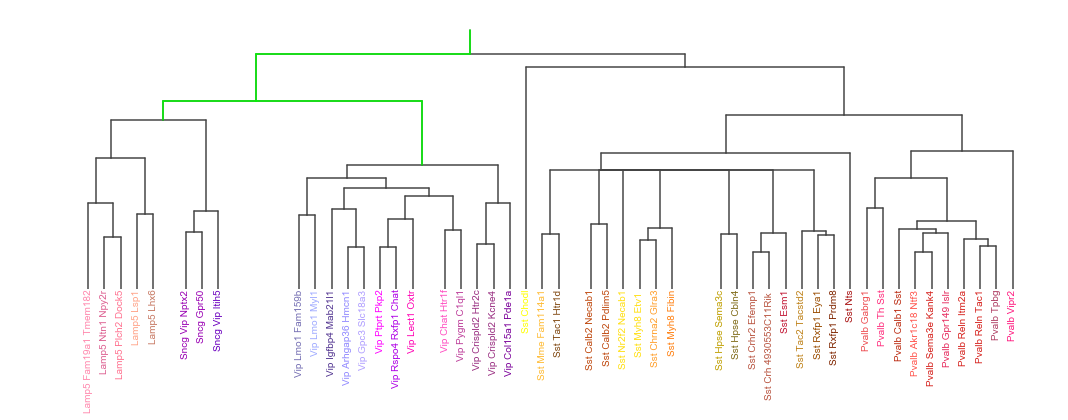

3 ['n60_3']


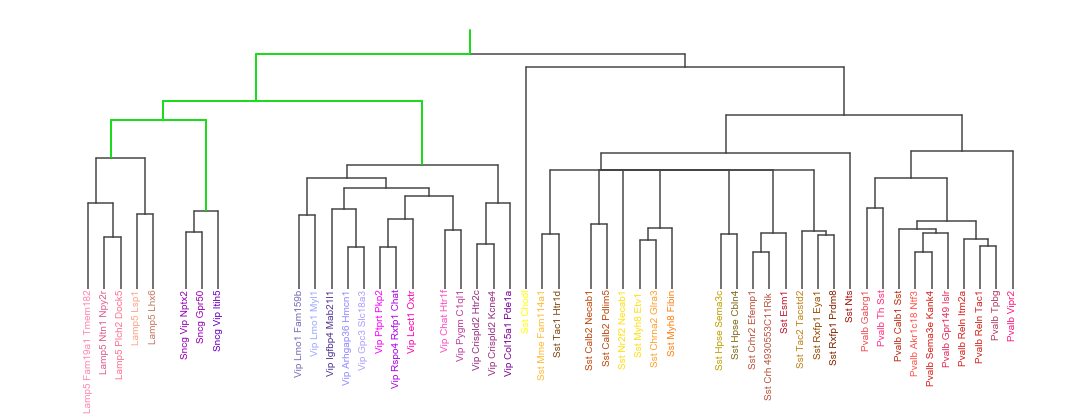

4 ['n60_8']


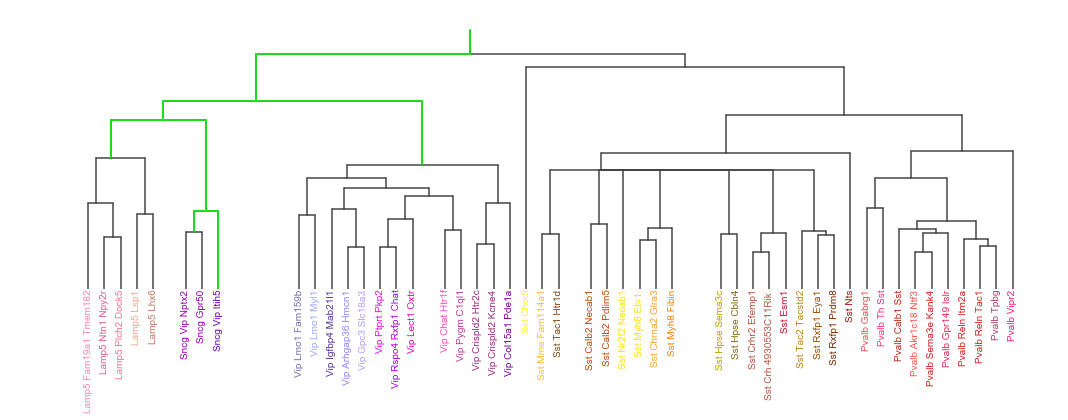

5 ['n60_20']


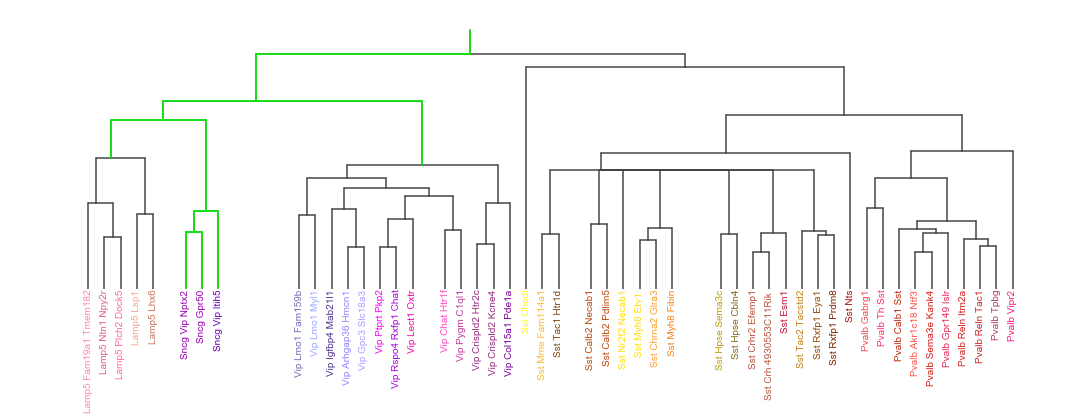

6 ['n60_38']


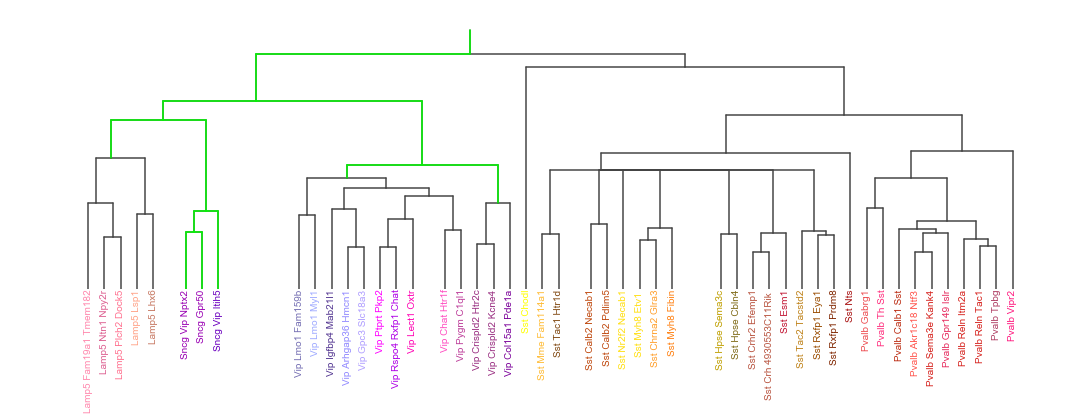

7 ['n60_59']


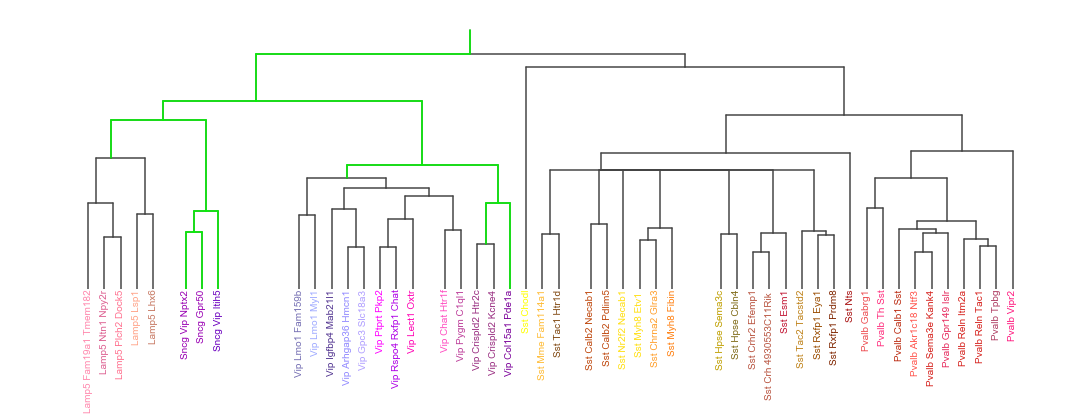

8 ['n60_97']


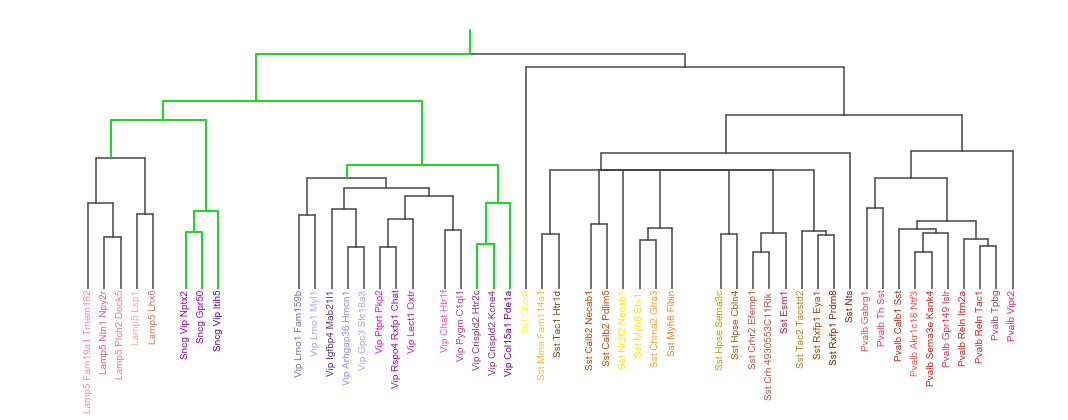

9 ['n60_220']


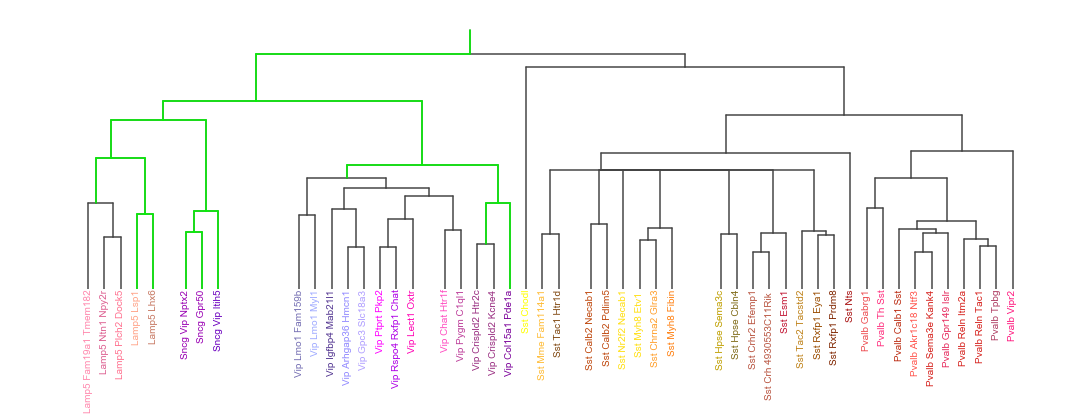

10 ['n60_321']


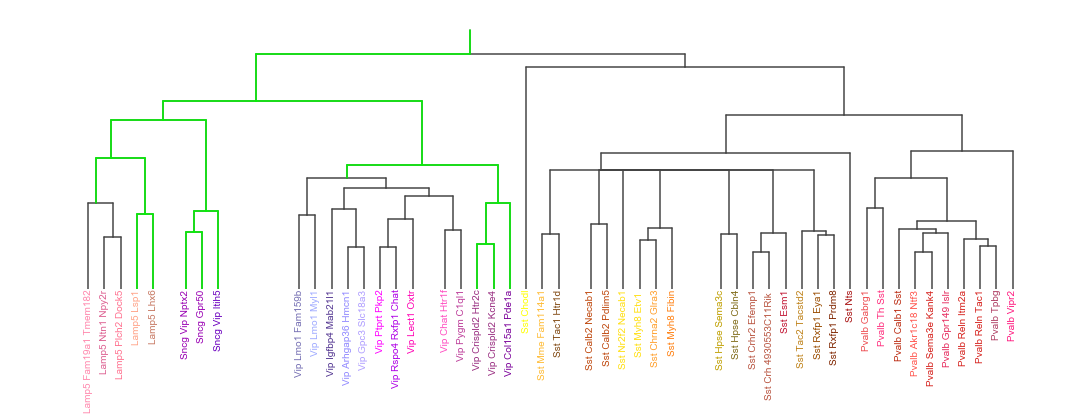

11 ['n60_560']


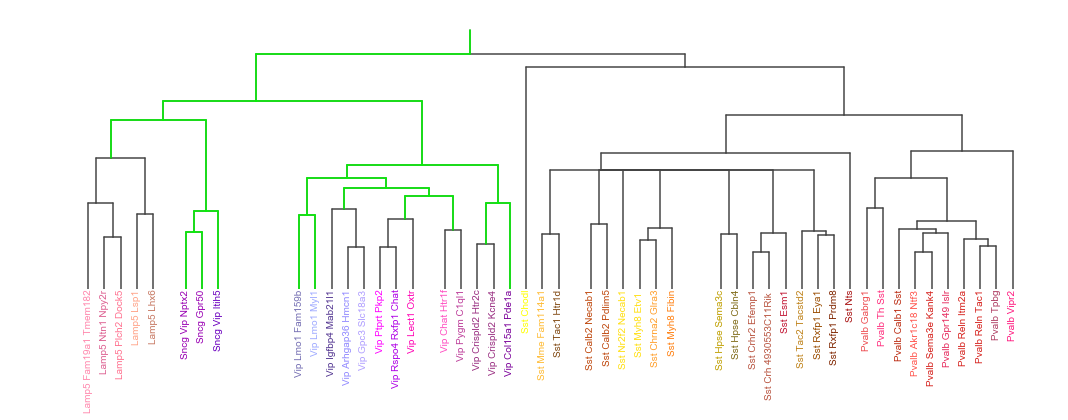

12 ['n60_838']


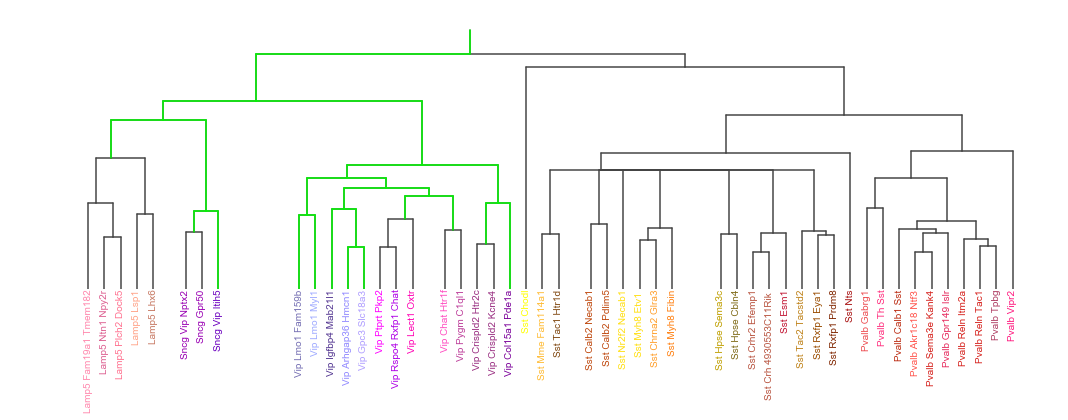

13 ['n60_1230']


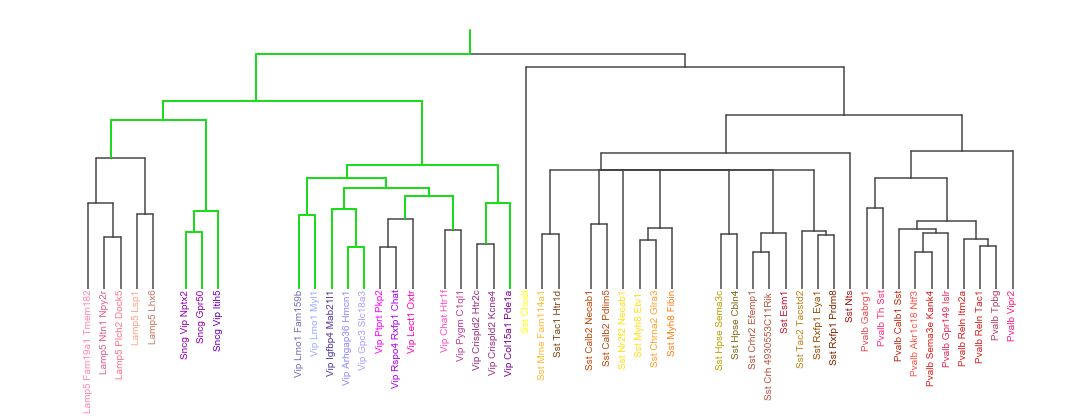

14 ['n60_1683']


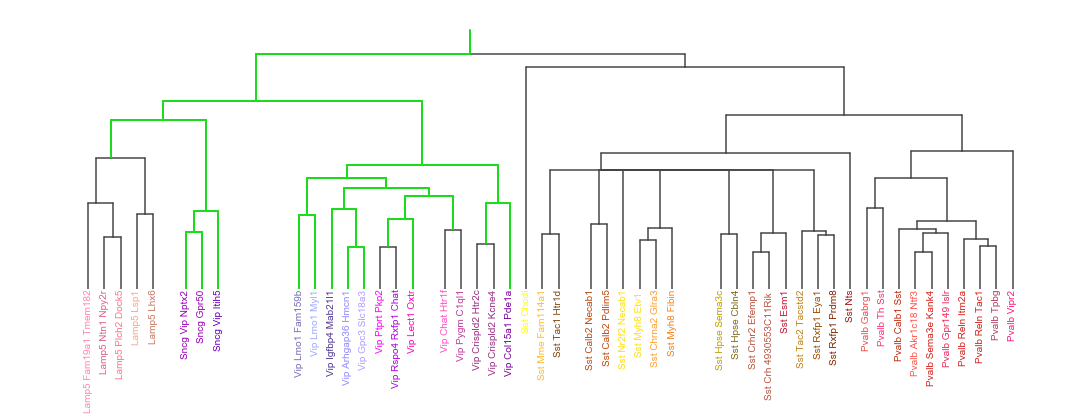

15 ['n60_1981']


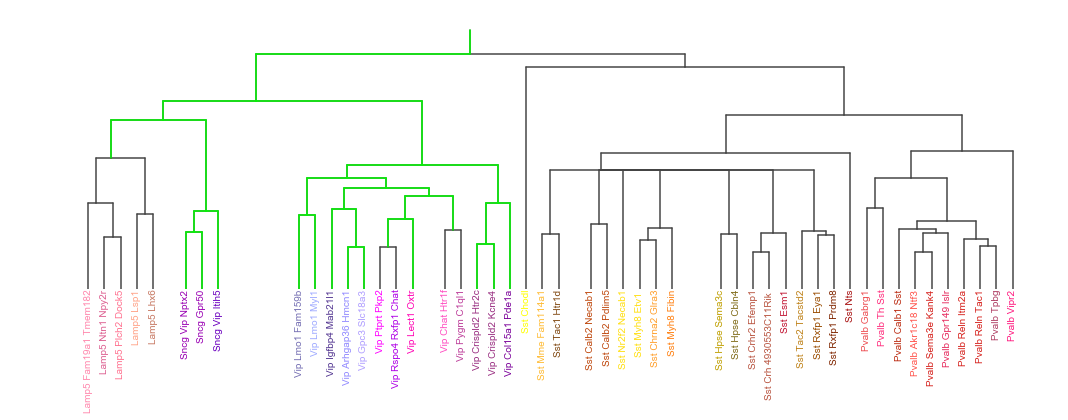

16 ['n60_2375']


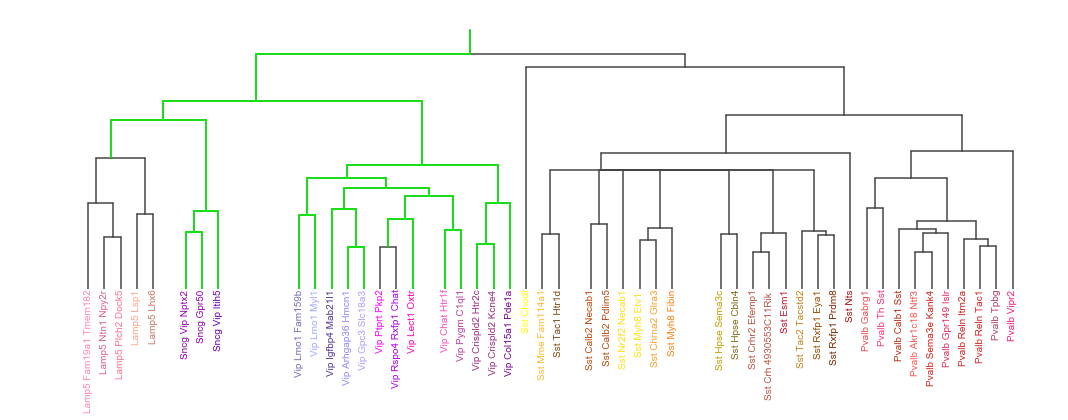

17 ['n60_2676']


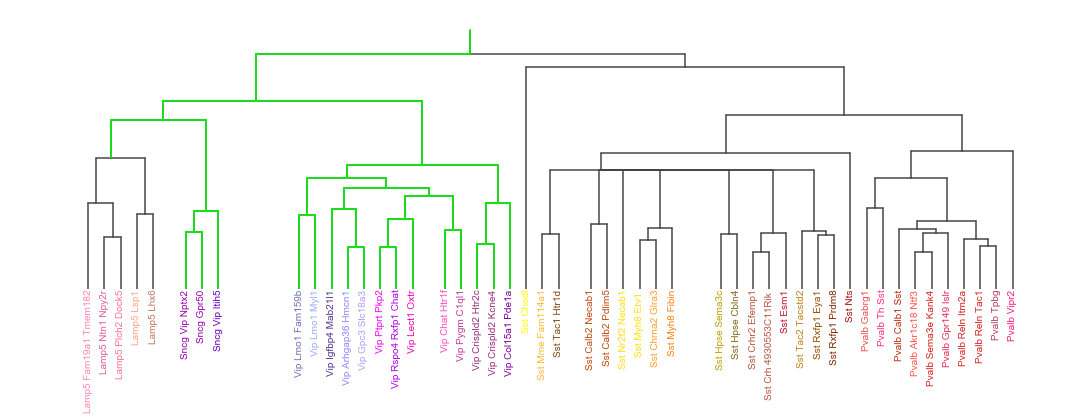

18 ['n60_2867']


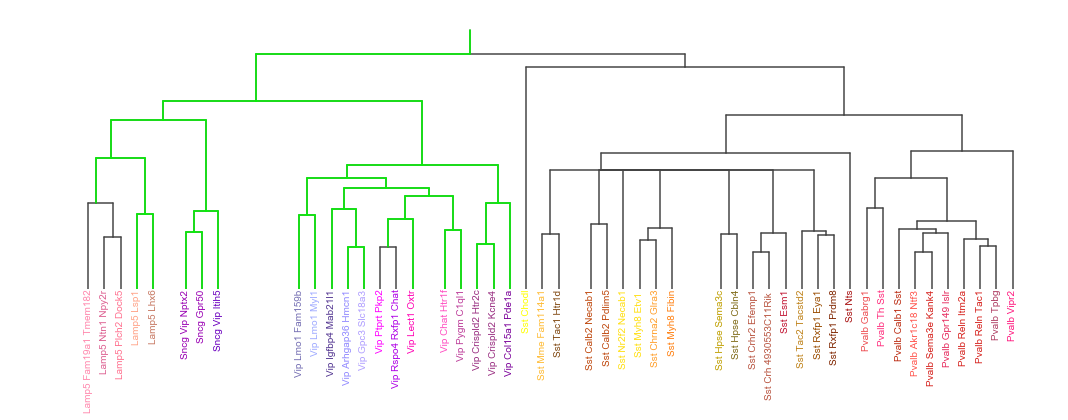

19 ['n60_2953']


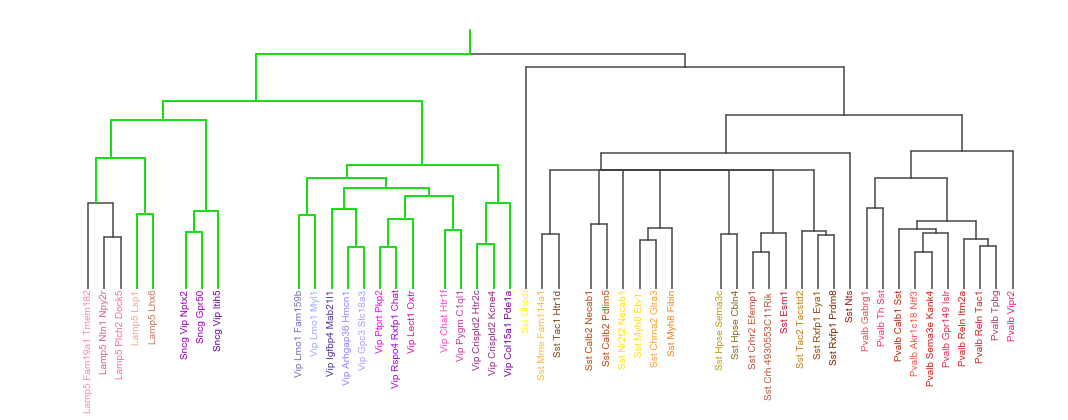

20 ['n60_2987']


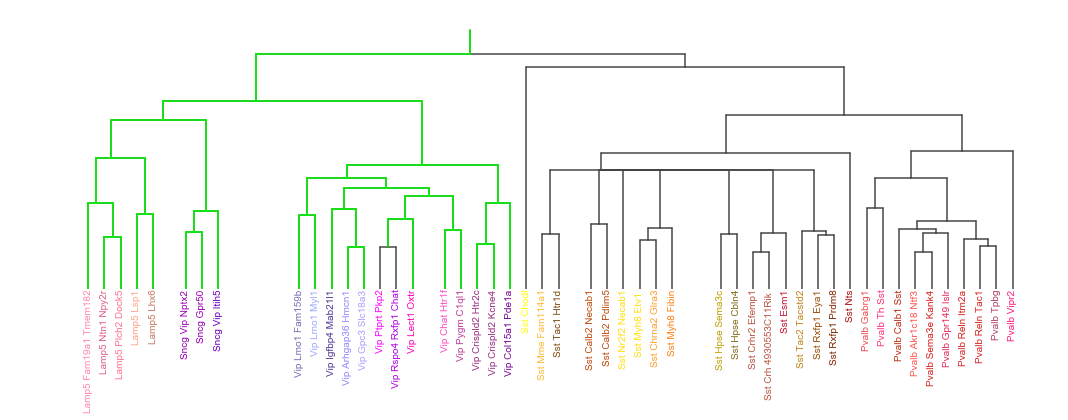

In [39]:
for cc in range(2,21,1):
    best_ind_60 = Y_n60_max['n_classes']==cc
    print(cc, Y_n60_max[best_ind_60]['classification_id'].values)
    Y_n60_max[best_ind_60]
    cid_60 = int(Y_n60_max[best_ind_60]['classification_id'].values[0][4:])

    kept_classes = all_classifications['n60'][cid_60]
    kepttree_nodes=[]
    for node in kept_classes:
        kepttree_nodes.extend(htree.get_ancestors(node))
        kepttree_nodes.extend([node])

    kept_subtree_df = htree.obj2df()
    kept_subtree=HTree(htree_df=kept_subtree_df[kept_subtree_df['child'].isin(kepttree_nodes)])

    htree.col[~htree.isleaf]='#999999'
    htree.plot((15,6),fontsize=10,skeletoncol='#444444',txtleafonly=True)
    kept_subtree.plot((15,5),skeletononly=True,skeletoncol='#00FF00',fig=plt.gcf())
    ax = plt.gca()
    ax.set_xlim(30,95)
    ax.axis('off')
    plt.tight_layout()
    #plt.savefig(save_pth+'2019-12-05-best_n60_htree_'+str(cc)+'_class.png',dpi=300)
    plt.show()

2 ['n88_1']


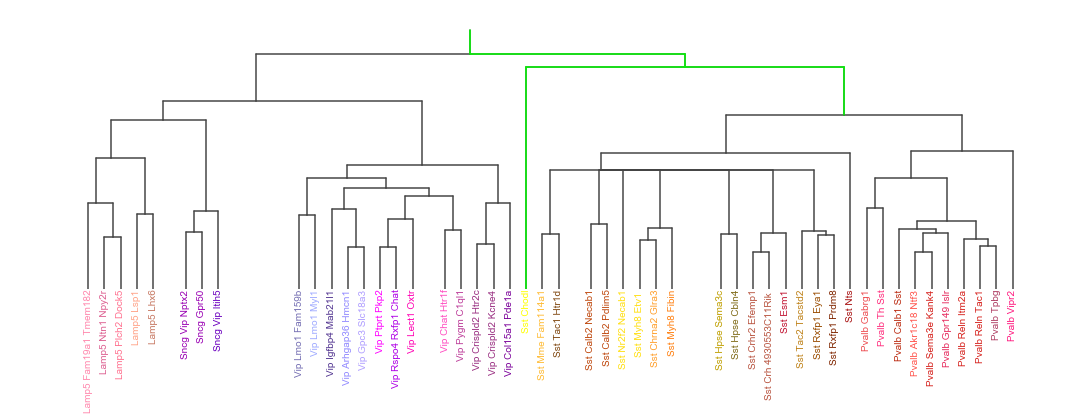

3 ['n88_2']


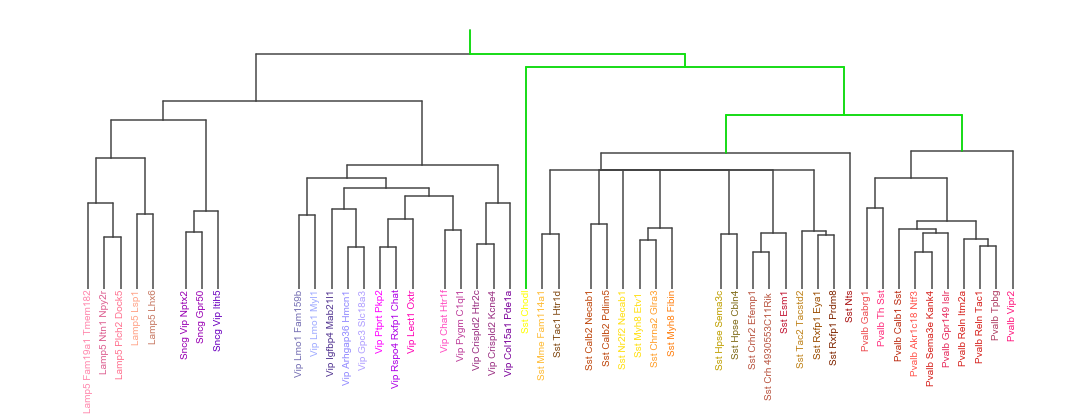

4 ['n88_3']


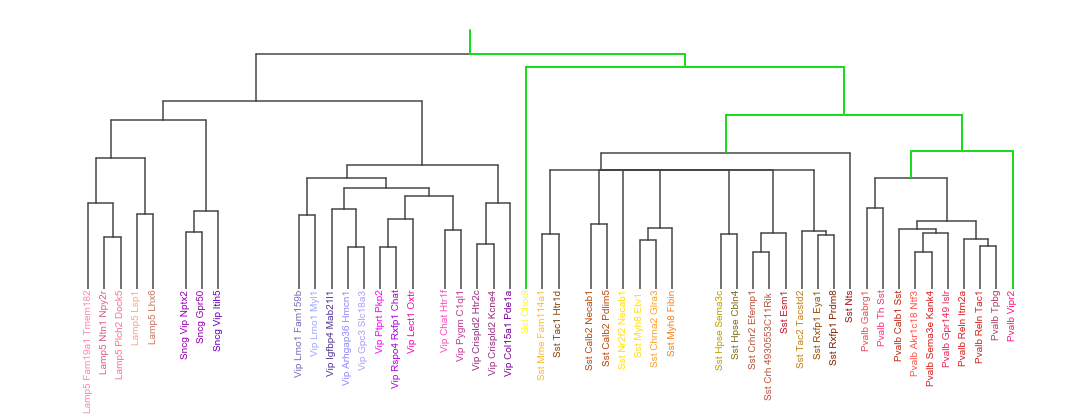

5 ['n88_5']


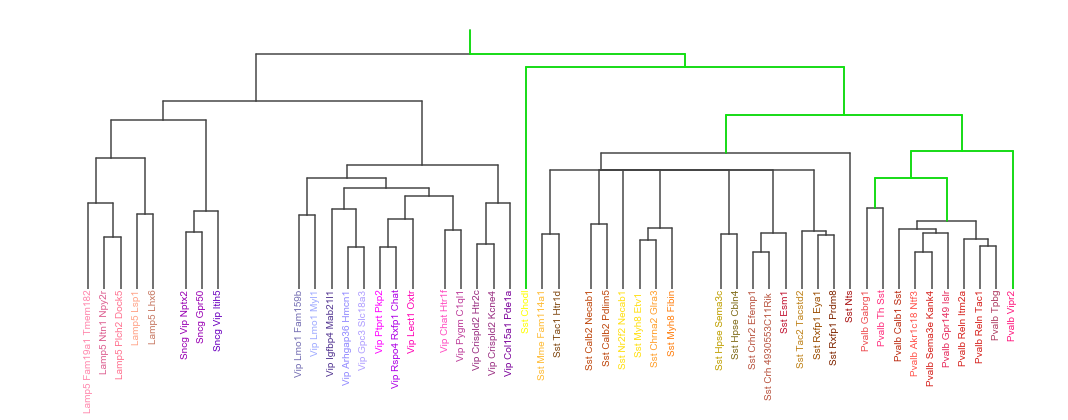

6 ['n88_8']


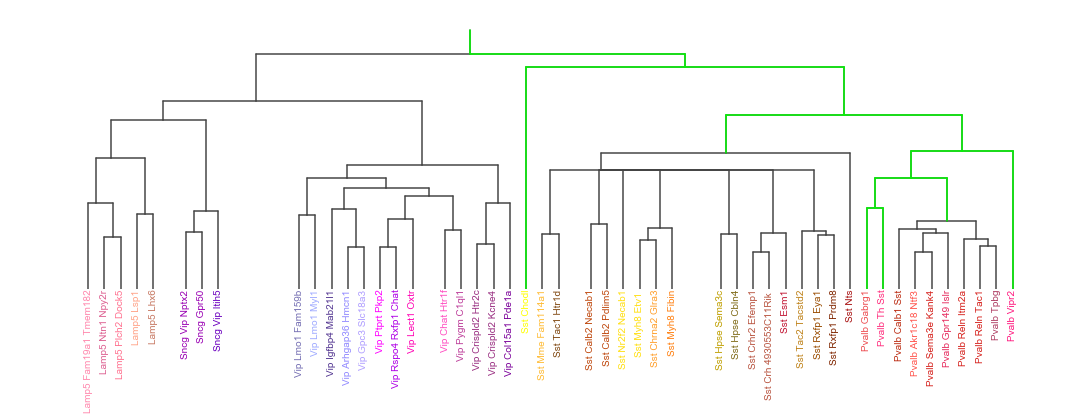

7 ['n88_12']


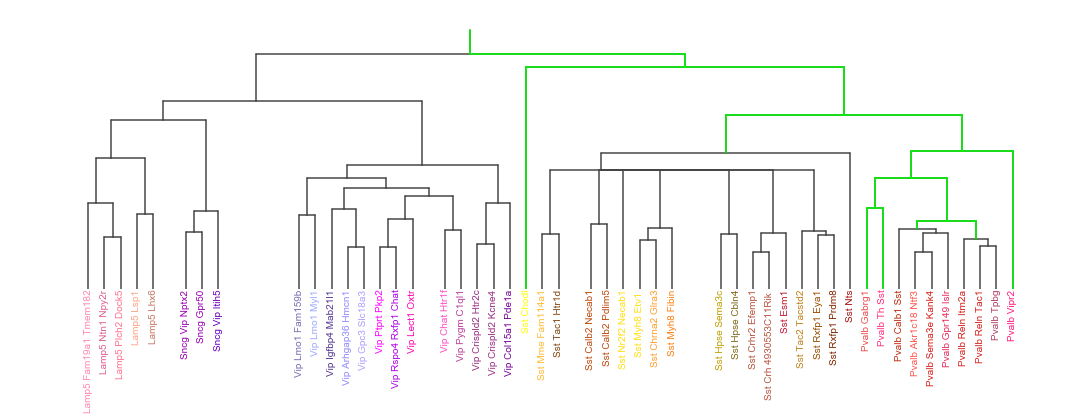

8 ['n88_20']


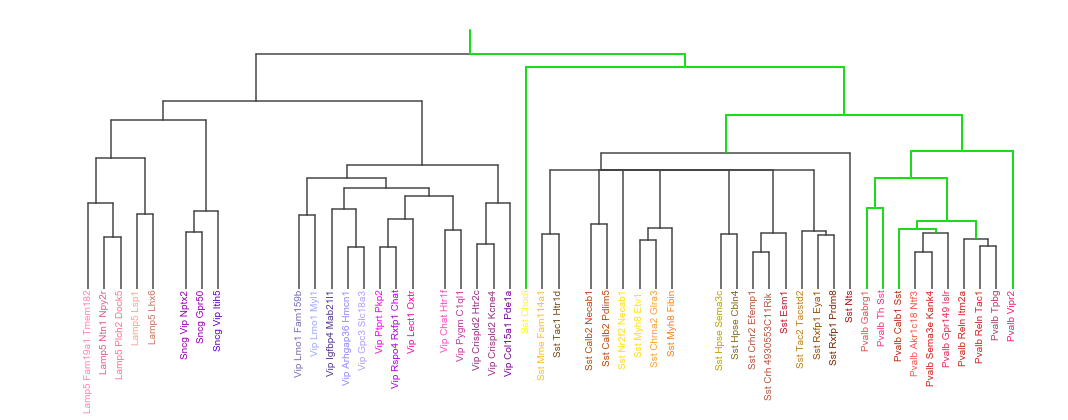

9 ['n88_31']


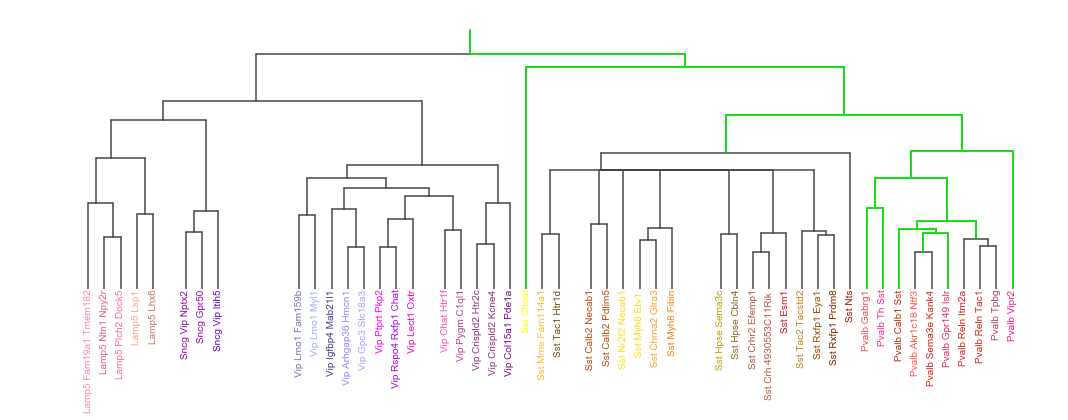

10 ['n88_42']


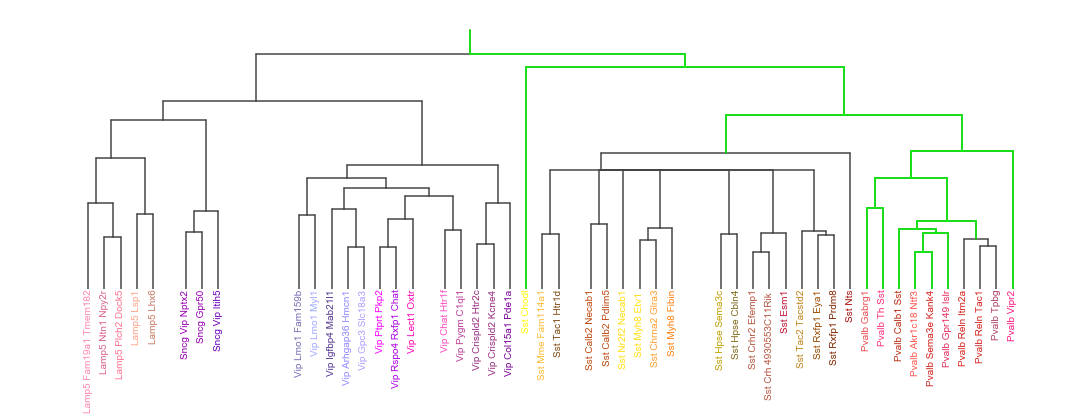

11 ['n88_47']


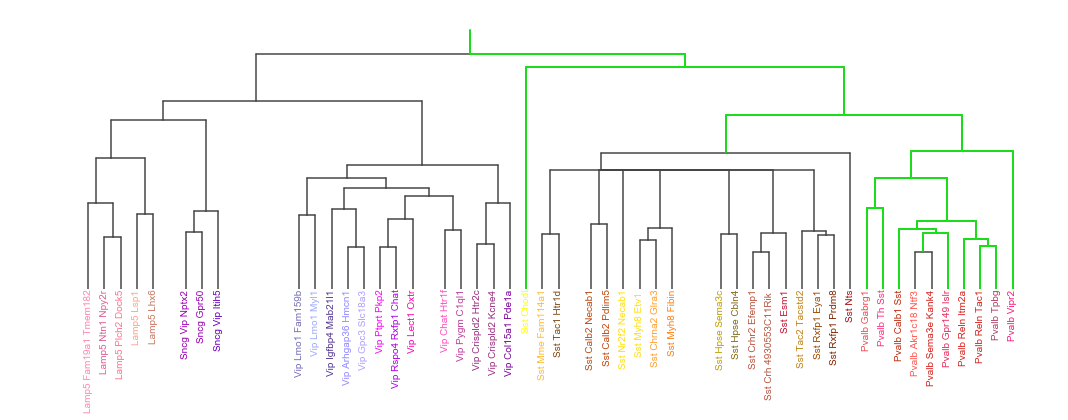

12 ['n88_70']


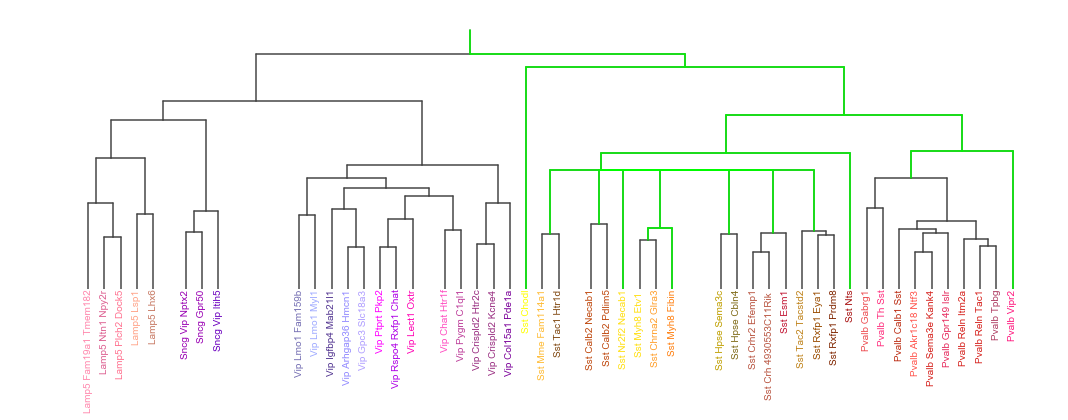

13 ['n88_114']


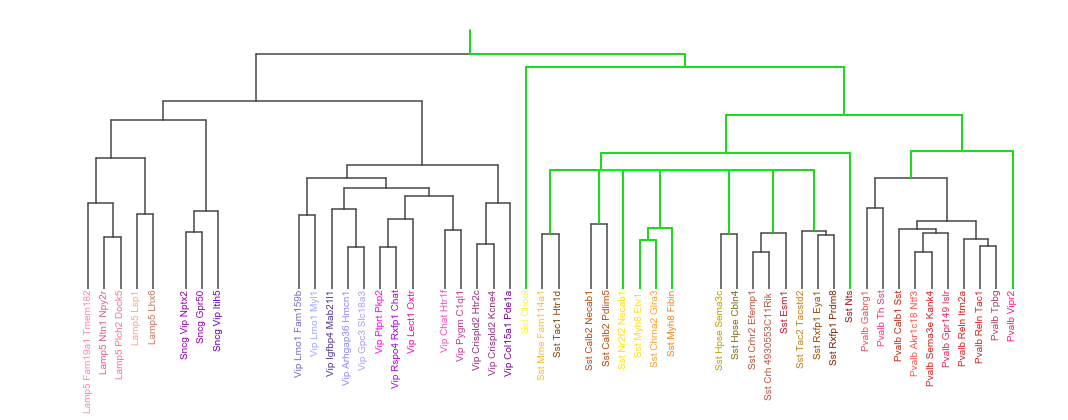

14 ['n88_218']


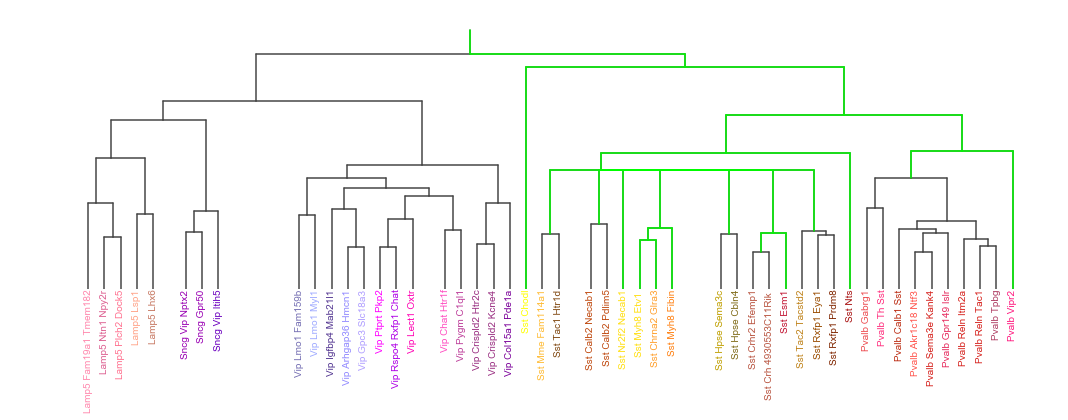

15 ['n88_409']


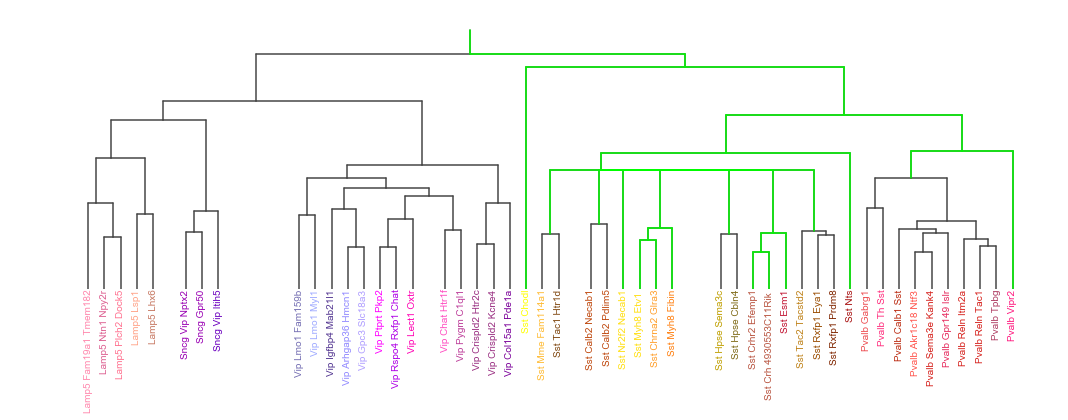

16 ['n88_713']


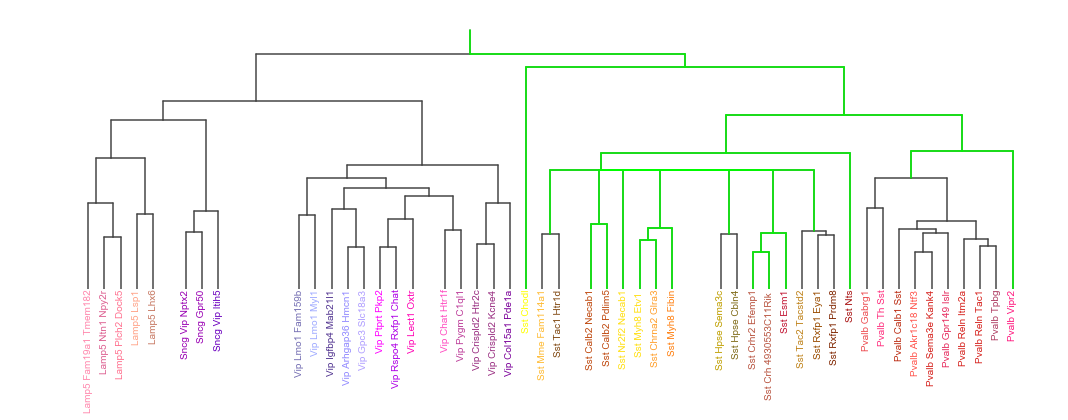

17 ['n88_1163']


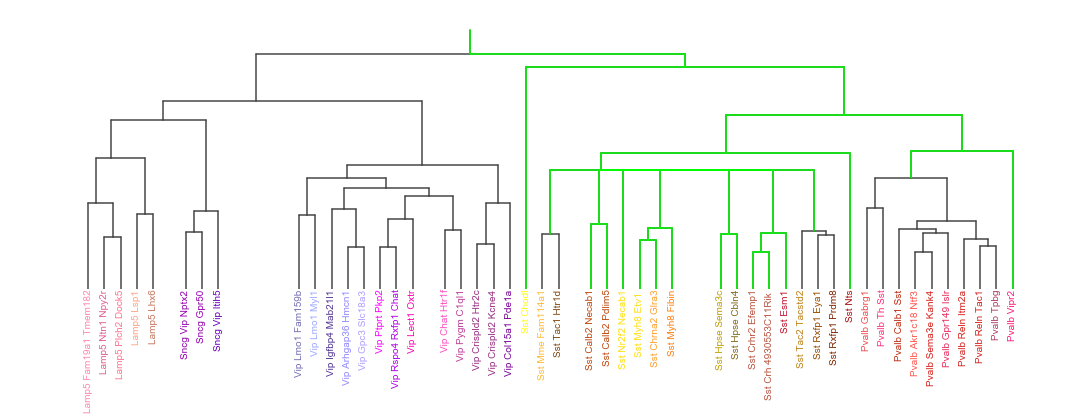

18 ['n88_1641']


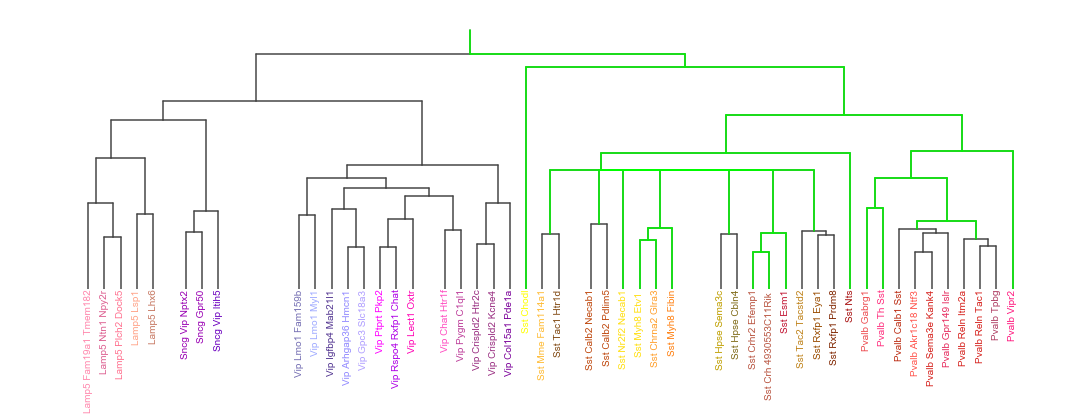

19 ['n88_2295']


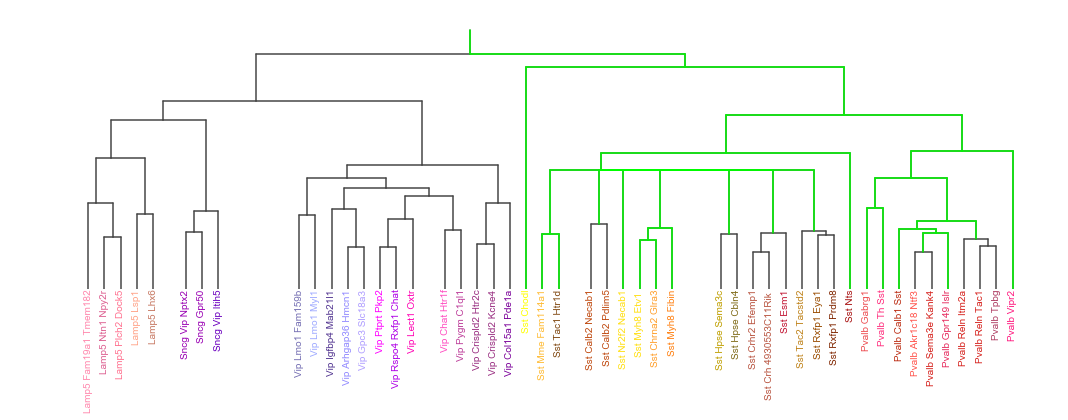

20 ['n88_3287']


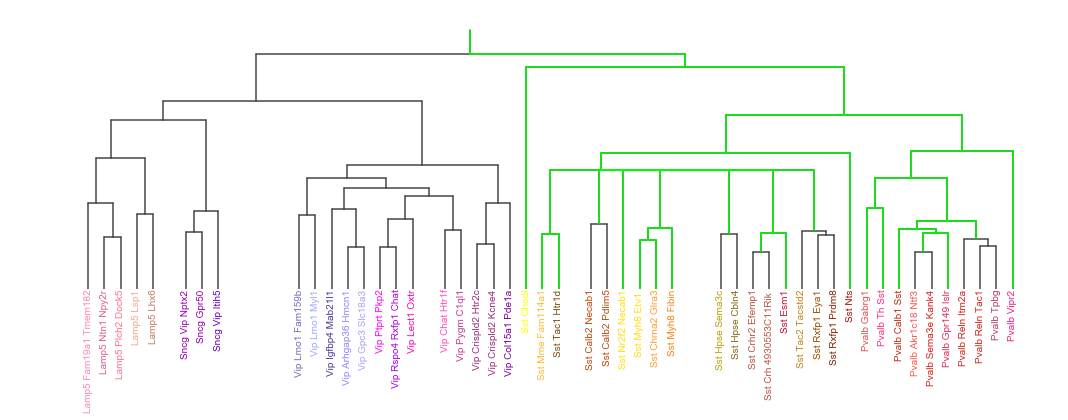

21 ['n88_4275']


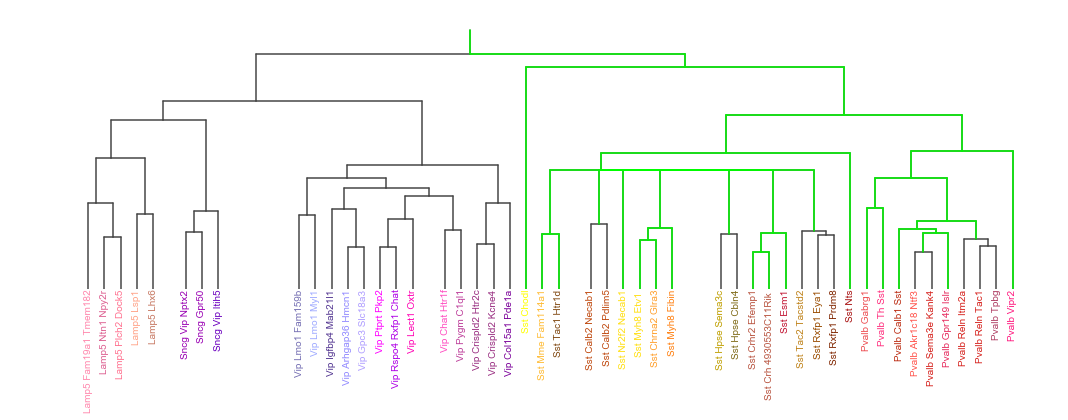

22 ['n88_5086']


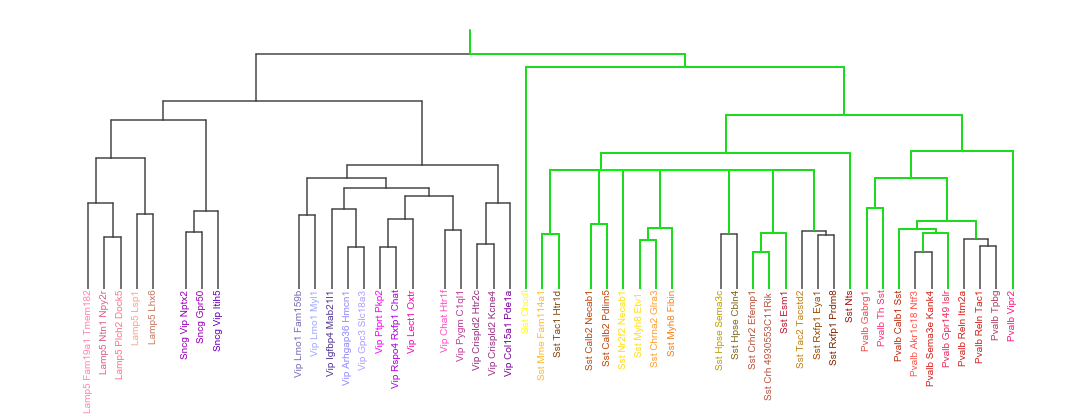

23 ['n88_5631']


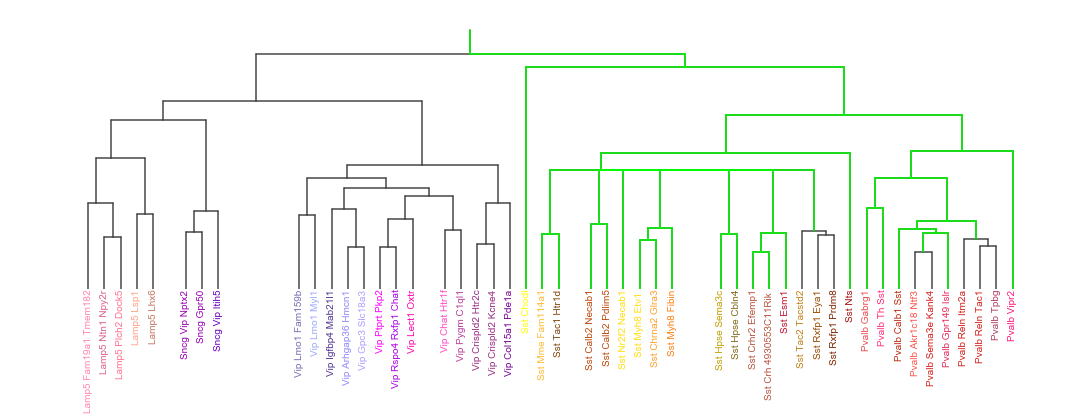

24 ['n88_5925']


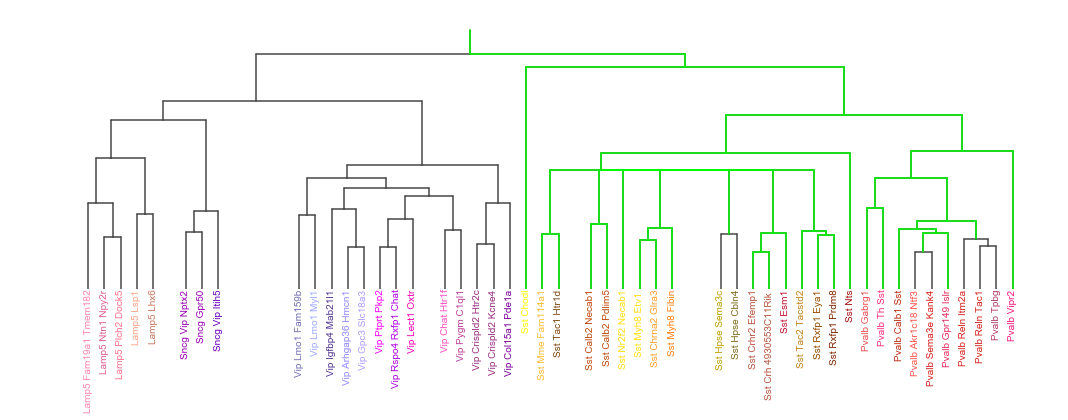

25 ['n88_6054']


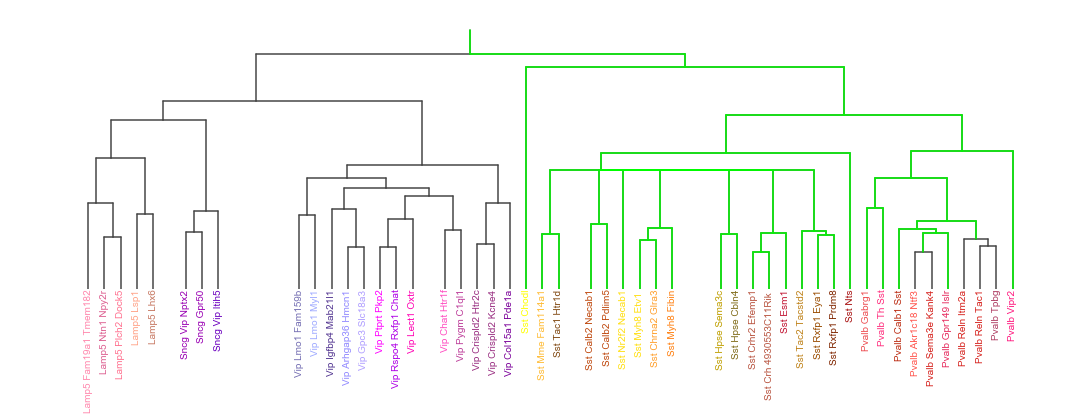

26 ['n88_6095']


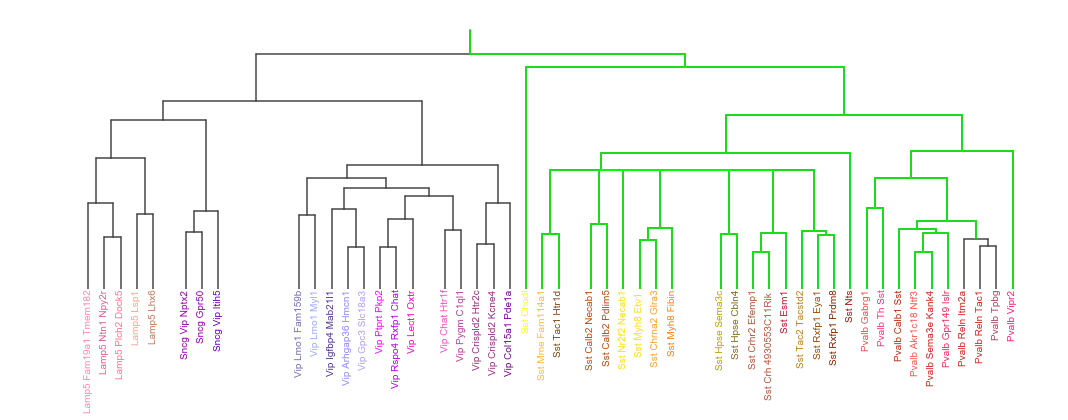

In [48]:
for cc in range(2,27,1):
    best_ind_88 = Y_n88_max['n_classes']==cc
    print(cc, Y_n88_max[best_ind_88]['classification_id'].values)
    Y_n88_max[best_ind_88]
    cid_88 = int(Y_n88_max[best_ind_88]['classification_id'].values[0][4:])

    kept_classes = all_classifications['n88'][cid_88]
    kepttree_nodes=[]
    for node in kept_classes:
        kepttree_nodes.extend(htree.get_ancestors(node))
        kepttree_nodes.extend([node])

    kept_subtree_df = htree.obj2df()
    kept_subtree=HTree(htree_df=kept_subtree_df[kept_subtree_df['child'].isin(kepttree_nodes)])

    htree.col[~htree.isleaf]='#999999'
    htree.plot((15,6),fontsize=10,skeletoncol='#444444',txtleafonly=True)
    kept_subtree.plot((15,5),skeletononly=True,skeletoncol='#00FF00',fig=plt.gcf())
    ax = plt.gca()
    ax.set_xlim(30,95)
    ax.axis('off')
    plt.tight_layout()
    #plt.savefig(save_pth+'2019-12-05-best_n88_htree_'+str(cc)+'_class.png',dpi=300)
    plt.show()